In [ ]:
%matplotlib inline

# MALARIA CLASSIFICATION

In [ ]:
#importing needed Libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# Mounting gdrive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
os.chdir('/content/drive/My Drive/Datasets/')

In [ ]:
base_dir = 'cell_images/'

train_dir = os.path.join(base_dir, 'training_images')
test_dir = os.path.join(base_dir, 'val_images')

# Visualize some infected and uninfected images

In [ ]:
infected = os.listdir(os.path.join(train_dir, 'Parasitized'))
uninfected = os.listdir(os.path.join(train_dir, 'Uninfected'))

In [ ]:
len(infected)

11023

In [ ]:
len(uninfected)

11023

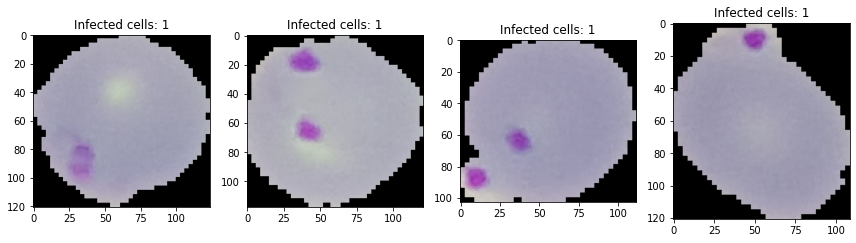

In [ ]:
plt.figure(figsize=(12,12))
for i in range(4):
  plt.subplot(1, 4, i + 1)
  timg = plt.imread(os.path.join(train_dir, 'Parasitized', infected[i + 1]))
  #plt.figure()
  plt.imshow(timg)
  plt.title('Infected cells: 1')
  plt.tight_layout()
plt.show()

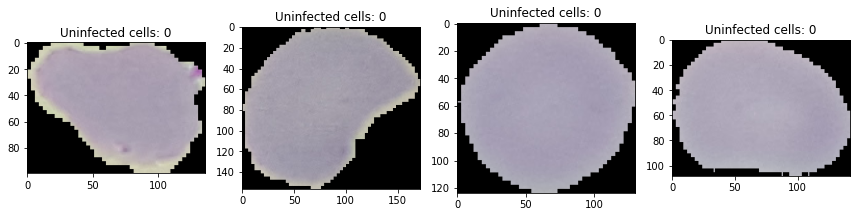

In [ ]:
plt.figure(figsize=(12,12))
for i in range(4):
  plt.subplot(1, 4, i+1)
  timg = plt.imread(os.path.join(train_dir, 'Uninfected', uninfected[i+1]))
  plt.imshow(timg)
  plt.title('Uninfected cells: 0')
  plt.tight_layout()
plt.show()

# Building Model

In [ ]:
#Initialize Image generators
#_________________________________________________
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='constant')
#_________________________________________________

test_datagen = ImageDataGenerator(rescale=(1./255.))

#_________________________________________________

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='categorical')

#_________________________________________________

validation_generator = train_datagen.flow_from_directory(test_dir,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print('Training reached 96%, stopping....')
      self.model.stop_training = True

In [ ]:
callback = myCallback()

# Using a pre-trainned model

In [ ]:
from keras.applications import VGG16

In [ ]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model = Sequential()

In [ ]:
model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [ ]:
model.compile(optimizer=keras.optimizers.Adadelta(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# Fitting data to model

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=22046/32,
                              epochs=50,
                              verbose=1,
                              
                              callbacks=[callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
689/688 [==============================] - 4575s 7s/step - loss: 0.6425 - accuracy: 0.6704
Epoch 2/50
689/688 [==============================] - 176s 255ms/step - loss: 0.2543 - accuracy: 0.9051
Epoch 3/50
689/688 [==============================] - 175s 254ms/step - loss: 0.2051 - accuracy: 0.9314
Epoch 4/50
689/688 [==============================] - 176s 256ms/step - loss: 0.1883 - accuracy: 0.9384
Epoch 5/50
689/688 [==============================] - 176s 255ms/step - loss: 0.1745 - accuracy: 0.9428
Epoch 6/50
689/688 [==============================] - 176s 256ms/step - loss: 0.1660 - accuracy: 0.9451
Epoch 7/50
689/688 [==============================] - 176s 255ms/step - loss: 0.1601 - accuracy: 0.9464
Epoch 8/50
689/688 [==============================] - 176s 255ms/step - loss: 0.1515 - accuracy: 0.9501


# Plot of train and validation accuracies

<Figure size 432x288 with 0 Axes>

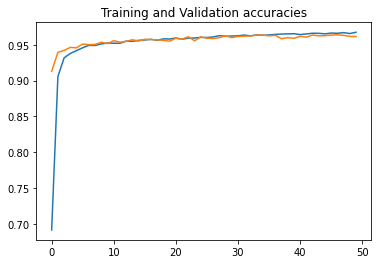

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#Get number of epochs
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation accuracies')
plt.figure()

# Plot of train and validation losses

<Figure size 432x288 with 0 Axes>

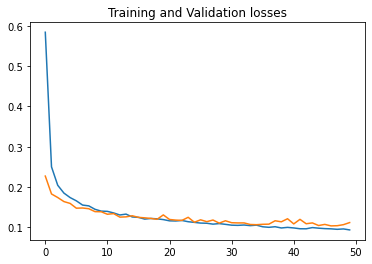

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation losses')
plt.figure()

# Save the trainned model

In [ ]:
model.save("Malaria_predictor_final_95.1.h5")

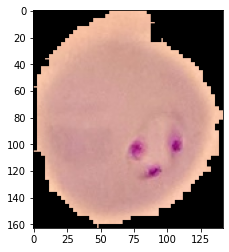

In [ ]:
test_img = 'test.png'
img = plt.imread(test_img)
plt.imshow(img)
plt.show()

In [ ]:
from keras.preprocessing import image
from keras.models import load_model
predictor = load_model('Malaria_predictor_final_95.1.h5')


In [ ]:
def predict(path):
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  pred_image = np.vstack([x])

  classes = predictor.predict(pred_image)
  #print(image)
  return classes

In [ ]:
path = 'test2.png'
path2 = 'test.png'


In [ ]:
predict(path)[0]

array([1.0000000e+00, 2.5904149e-12], dtype=float32)

In [ ]:
pred = predict(path)

In [ ]:
pred

array([[1.0000000e+00, 2.5904149e-12]], dtype=float32)

In [ ]:
for i in pred:
  if (i[0] > i[1]):
    print('Cell is infected')
  else:
    print('Cell is uninfected')

Cell is infected
